## Objectives

* Answer business requirement one:
  * The client wishes us to conduct an analysis of current elite-level golf tournament data 
    to determine which golfing skills (e.g., driving, approach play, chipping, and putting) 
    are most likely to result in a player reaching the top ten of a tournament. 
    They are specifically interested in learning which skill to focus on to help a player 
    improve from a 30th–11th place finish to a top-ten finish.

## Inputs

* inputs\datasets\raw\ASA All PGA Raw Data - Tourn Level.csv

## Outputs

* Generate code that answers business requirement 1 and can be used to build the StreamLit App.

## Additional Comments

* Although more will be done later, a level of data cleaning is done in this notebook to sort the confusion in the data between 'pos' and 'finish' features discovered in the previous notebook. This was necessary at this stage to avoid analysing data with errors. 


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os
current_dir = os.getcwd()
current_dir

'c:\\project-five-golf-data-analytics\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

'c:\\project-five-golf-data-analytics'

In [ ]:
df_temp['top_ten'] = np.where(df_temp['true_pos'].between(1, 10, inclusive='both'), 1, 0)
print(df_temp['top_ten'].value_counts())

top_ten
0    33116
1     3748
Name: count, dtype: int64


## Analyse average strokes gained data for top_ten vs not top_ten finishers.

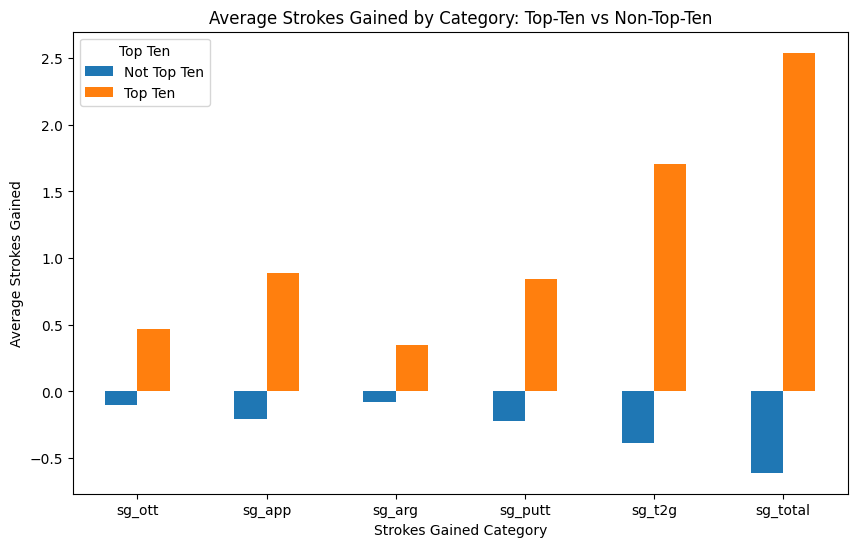

In [ ]:
import matplotlib.pyplot as plt

sg_features = ['sg_ott', 'sg_app', 'sg_arg', 'sg_putt', 'sg_t2g', 'sg_total']

avg_sg = df_temp.groupby('top_ten')[sg_features].mean()

avg_sg.T.plot(kind='bar', figsize=(10,6))
plt.title('Average Strokes Gained by Category: Top-Ten vs Non-Top-Ten')
plt.xlabel('Strokes Gained Category')
plt.ylabel('Average Strokes Gained')
plt.xticks(rotation=0)
plt.legend(title='Top Ten', labels=['Not Top Ten', 'Top Ten'])
plt.show()



Next check the differences for each strokes gained stat between a top ten player and a not top ten player.

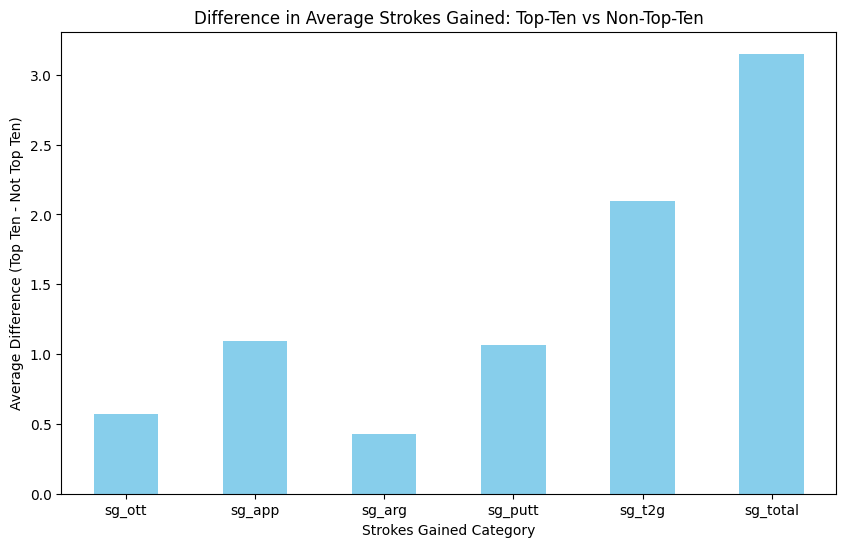

In [ ]:
diff_sg = avg_sg.loc[1] - avg_sg.loc[0]

plt.figure(figsize=(10,6))
diff_sg.plot(kind='bar', color='skyblue')
plt.title('Difference in Average Strokes Gained: Top-Ten vs Non-Top-Ten')
plt.xlabel('Strokes Gained Category')
plt.ylabel('Average Difference (Top Ten - Not Top Ten)')
plt.xticks(rotation=0)
plt.show()

It is not a surprise that 'strokes gained total' and 'strokes gained tee to green' dominate in the above plots. They are statistics that combine multiple shot types and will therefore certainly have a bigger impact. Disregarding them, putting and approach play seem to be the biggest indicators of successful golf that is likely to produce a top ten finish.

A pairplot can be used to visualise pairwise relationships between strokes gained features.

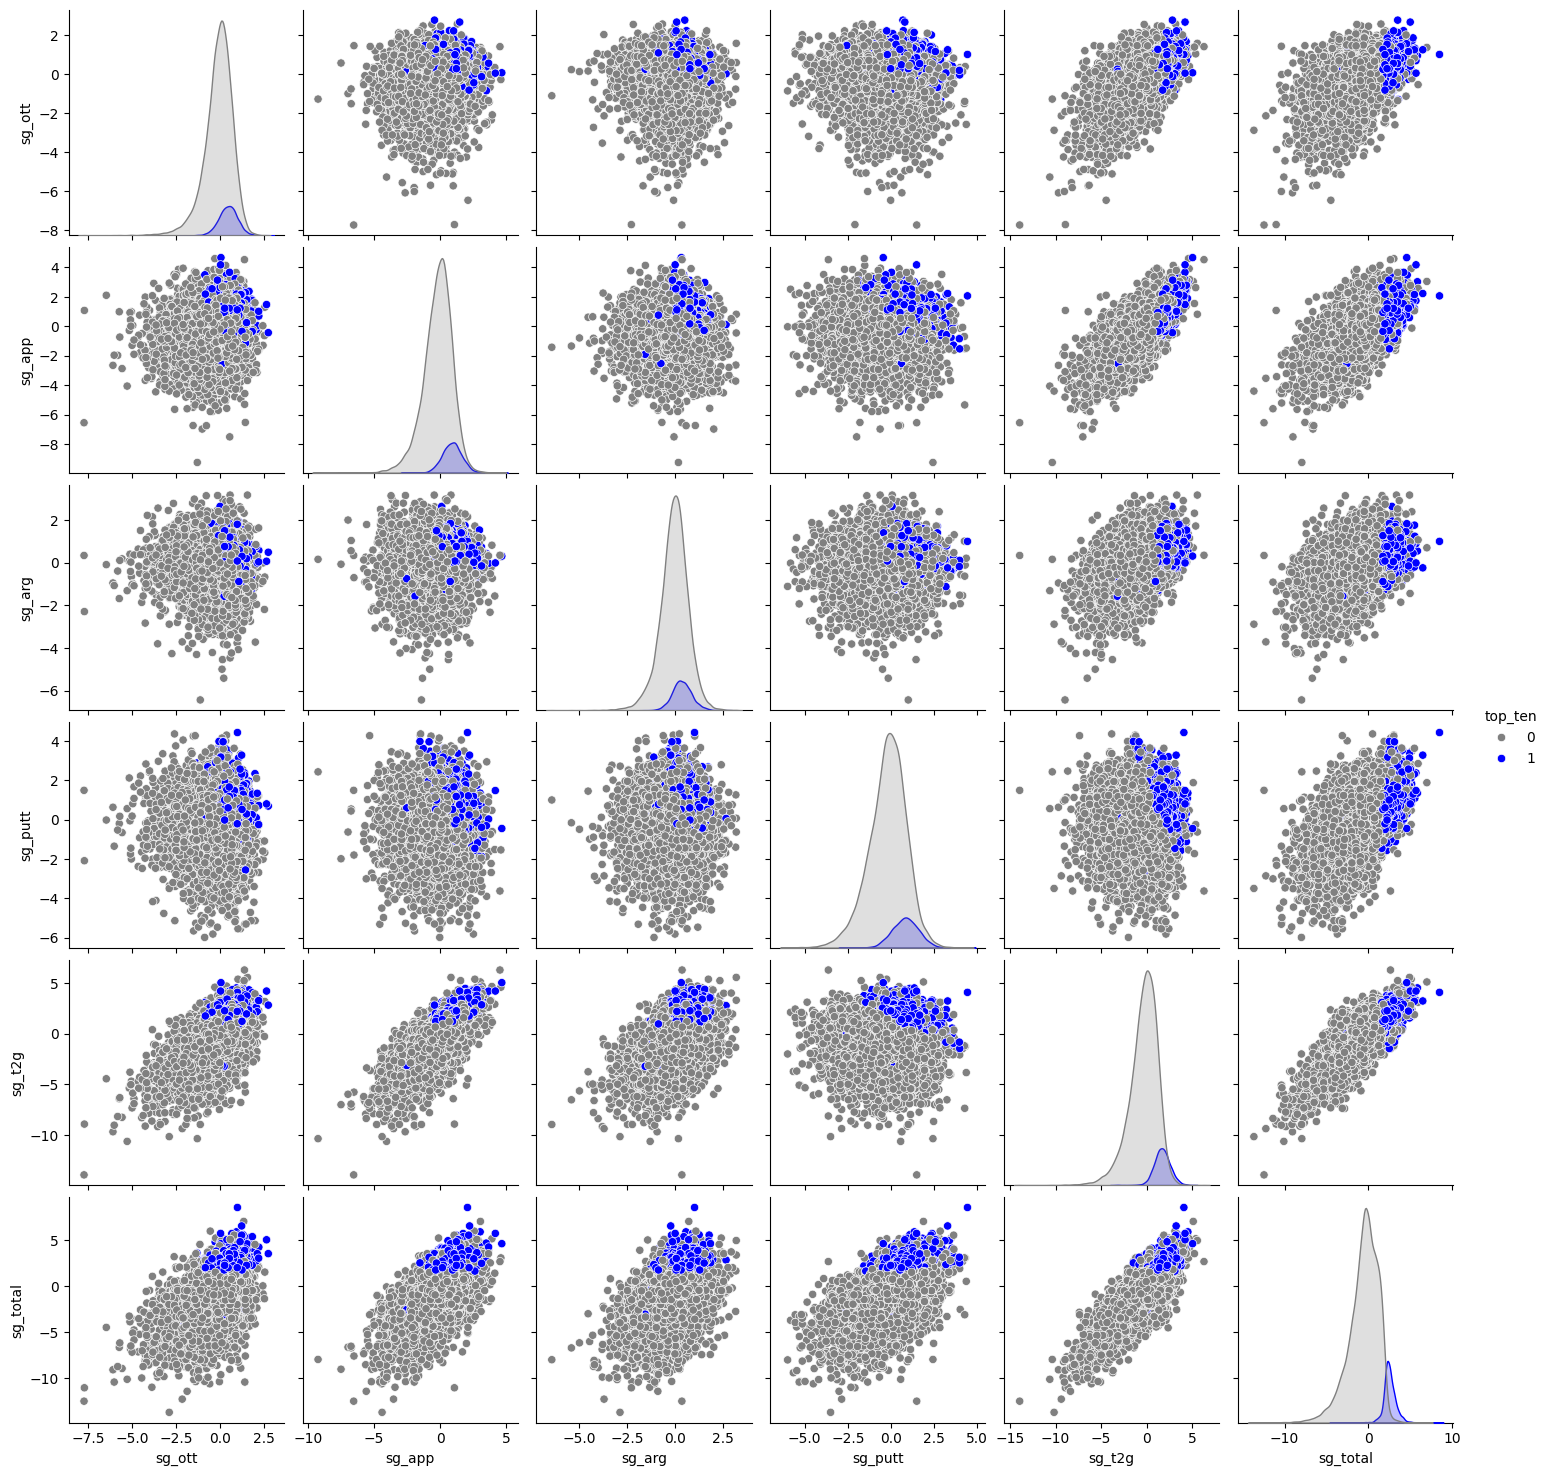

In [ ]:
import seaborn as sns

sns.pairplot(df_temp[sg_features + ['top_ten']], hue='top_ten', palette=['grey','blue'])
plt.show()


This indicates that, in general, all strokes gained stastics are important in a high level golf performance. However, there are some examples where a particularly good performance in one area can counteract a slightly negative performance in another, such as the comparison between 'approach' and 'putting'.

## Heatmaps to analyse correlations with different features and a top ten finish.

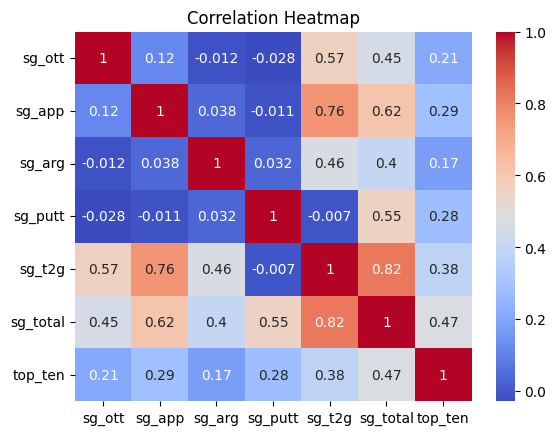

In [ ]:
sns.heatmap(df_temp[sg_features + ['top_ten']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


Higher correlations between strokes gained stats and top_ten were expected. On reflection, the binary nature of the 'top_ten' data has create issues in that players who finished just outside the top ten would still have very similar strokes gained stats and are skewing the data. Also, a Pearson correlation method was used and strokes gained data is irregular and non-linear, a Spearman correlation may be a better solution.

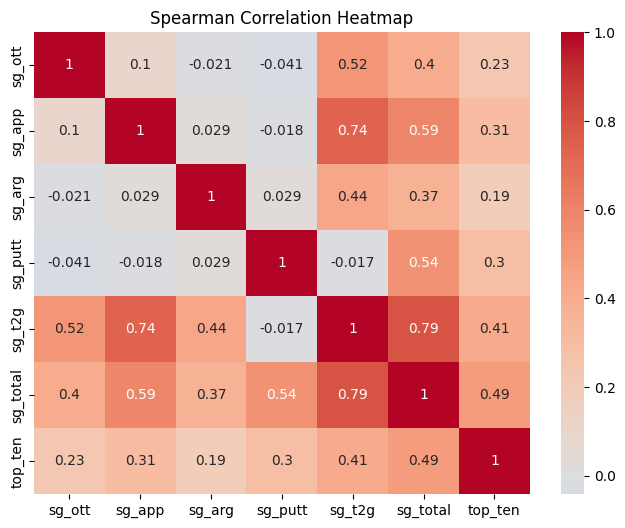

In [ ]:
corr_spearman = df_temp[sg_features + ['top_ten']].corr(method='spearman')

plt.figure(figsize=(8,6))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', center=0)
plt.title('Spearman Correlation Heatmap')
plt.show()


A Spearman correlation showed slightly stronger relationships between the strokes gained metrics and top-ten finishes; however, the binary nature of the ‘top_ten’ variable still introduces a degree of noise into the analysis. A Spearman correlation heatmap comparing the strokes gained statistics to a true positive indicator (e.g., 'true_pos') may provide a more effective way to visualise and interpret these relationships.

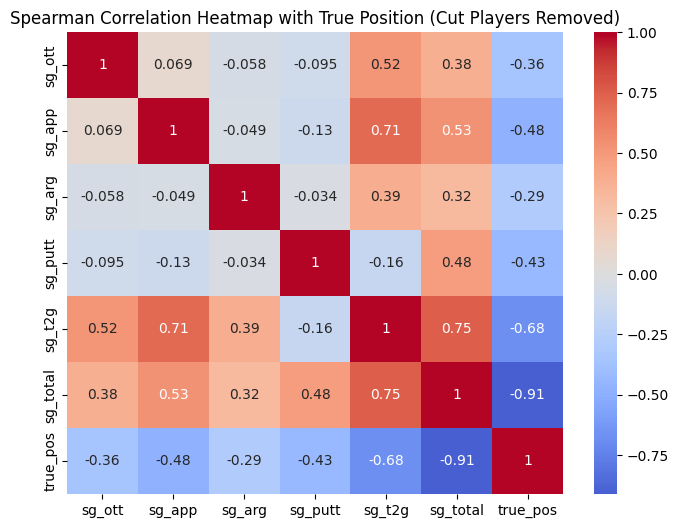

In [ ]:
sg_features = ['sg_ott', 'sg_app', 'sg_arg', 'sg_putt', 'sg_t2g', 'sg_total']

df_filtered = df_temp[df_temp['true_pos'] > 0]

corr_spearman = df_filtered[sg_features + ['true_pos']].corr(method='spearman')

plt.figure(figsize=(8,6))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', center=0)
plt.title('Spearman Correlation Heatmap with True Position (Cut Players Removed)')
plt.show()



This now does show a somewhat more significant relationship between strokes gained and finishing position in tournaments. 
Across all these plots, conclusions can be reached that approach play and putting are the biggest factors in determining top ten finishes.
However, overall the correlations between the strokes gained metrics and good tournament finishes remain relatively weak, reflecting the multi-faceted nature of golf performance. Tournament outcomes are influenced by a combination of technical skills, course conditions, mental factors, and variability across rounds, making it difficult for any single metric to show strong predictive power. This must be emphasised to the client.

## Highlighting players who are currently finishing 30-11th and wish to improve to the top 10.

The client specifically requested information on players who are currently finishing between 30th and 11th on a regular basis and wish to improve to reach the top ten and the next plots shall analyse that.
First, to extract groups of 'top ten- elite players, and 'mid-level' players.

In [ ]:
top_players = (
    df_temp.groupby('player id')
    .agg(
        top_ten_finishes=('top_ten', 'sum'),
        avg_sg_putt=('sg_putt', 'mean'),
        avg_sg_arg=('sg_arg', 'mean'),
        avg_sg_app=('sg_app', 'mean'),
        avg_sg_ott=('sg_ott', 'mean'),
        avg_sg_t2g=('sg_t2g', 'mean'),
        avg_sg_total=('sg_total', 'mean')
    )
    .reset_index()
)

top_15_players = top_players.sort_values(by='top_ten_finishes', ascending=False).head(15)

print(top_15_players)


     player id  top_ten_finishes  avg_sg_putt  avg_sg_arg  avg_sg_app  \
172       3448                70     0.163519    0.053056    0.419630   
236       4848                68    -0.029225    0.258217    0.646512   
256       5467                62     0.241746    0.296667    0.308571   
177       3470                58    -0.042683    0.195854    0.432073   
379       9780                58     0.249022    0.136630    0.370109   
269       5579                50     0.376250    0.267647   -0.016029   
157       2230                50    -0.123557    0.107852    0.290201   
282       5860                48    -0.258889    0.194444    0.681270   
311       6798                47     0.138468    0.027928    0.135946   
190       3702                46     0.114380    0.250000    0.097438   
59         569                46     0.119889    0.115333    0.240111   
134       1614                44     0.076777    0.337273    0.498678   
143       1680                43     0.314245    0.

In [ ]:
if 'player id' not in player_stats.columns:
    player_stats = player_stats.reset_index().rename(columns={player_stats.index.name: 'player id'})

top_15_mid_pct = player_stats.sort_values(by='mid_band_pct', ascending=False).head(15).reset_index(drop=True)

if 'player id' not in top_15_players.columns:
    top_15_players = top_15_players.reset_index().rename(columns={top_15_players.index.name: 'player id'})
top_15_players = top_15_players.reset_index(drop=True)

top_ten_players_list = top_15_players['player id'].tolist()

filtered_mid_band = top_15_mid_pct[
    ~top_15_mid_pct['player id'].isin(top_ten_players_list)
]
num_needed = 15 - filtered_mid_band.shape[0]

remaining_players = player_stats[
    ~player_stats['player id'].isin(
        top_ten_players_list + filtered_mid_band['player id'].tolist()
    )
].sort_values(by='mid_band_pct', ascending=False)

top_15_mid_pct = pd.concat([filtered_mid_band, remaining_players.head(num_needed)], ignore_index=True)

print(top_15_mid_pct)




    player id  total_tournaments  mid_band_finishes  mid_band_pct  \
0        9931                 28                 11      0.392857   
1        1293                122                 47      0.385246   
2        9243                 37                 14      0.378378   
3       10906                 28                 10      0.357143   
4       10140                126                 42      0.333333   
5        5539                 90                 30      0.333333   
6        9031                 39                 13      0.333333   
7        5553                 88                 29      0.329545   
8        6007                 99                 32      0.323232   
9     4364873                 65                 21      0.323077   
10       5956                 29                  9      0.310345   
11       9478                 73                 22      0.301370   
12       9025                167                 50      0.299401   
13       9126                125  

We need to ensure that there is no overlap between elite players and mid-range players for the data to be a success.

In [ ]:
if 'player id' not in player_stats.columns:
    player_stats = player_stats.reset_index().rename(columns={player_stats.index.name: 'player id'})

top_15_mid_pct = top_15_mid_pct.reset_index(drop=True)
top_15_players = top_15_players.reset_index(drop=True)

top_ten_players_list = top_15_players['player id'].tolist()

filtered_mid_band = top_15_mid_pct[
    ~top_15_mid_pct['player id'].isin(top_ten_players_list)
]
num_needed = 15 - filtered_mid_band.shape[0]

remaining_players = player_stats[
    ~player_stats['player id'].isin(
        top_ten_players_list + filtered_mid_band['player id'].tolist()
    )
].sort_values(by='mid_band_pct', ascending=False)

new_mid_band_list = pd.concat([filtered_mid_band, remaining_players.head(num_needed)], ignore_index=True)

print(new_mid_band_list)





    player id  total_tournaments  mid_band_finishes  mid_band_pct  \
0        9931                 28                 11      0.392857   
1        1293                122                 47      0.385246   
2        9243                 37                 14      0.378378   
3       10906                 28                 10      0.357143   
4       10140                126                 42      0.333333   
5        5539                 90                 30      0.333333   
6        9031                 39                 13      0.333333   
7        5553                 88                 29      0.329545   
8        6007                 99                 32      0.323232   
9     4364873                 65                 21      0.323077   
10       5956                 29                  9      0.310345   
11       9478                 73                 22      0.301370   
12       9025                167                 50      0.299401   
13       9126                125  

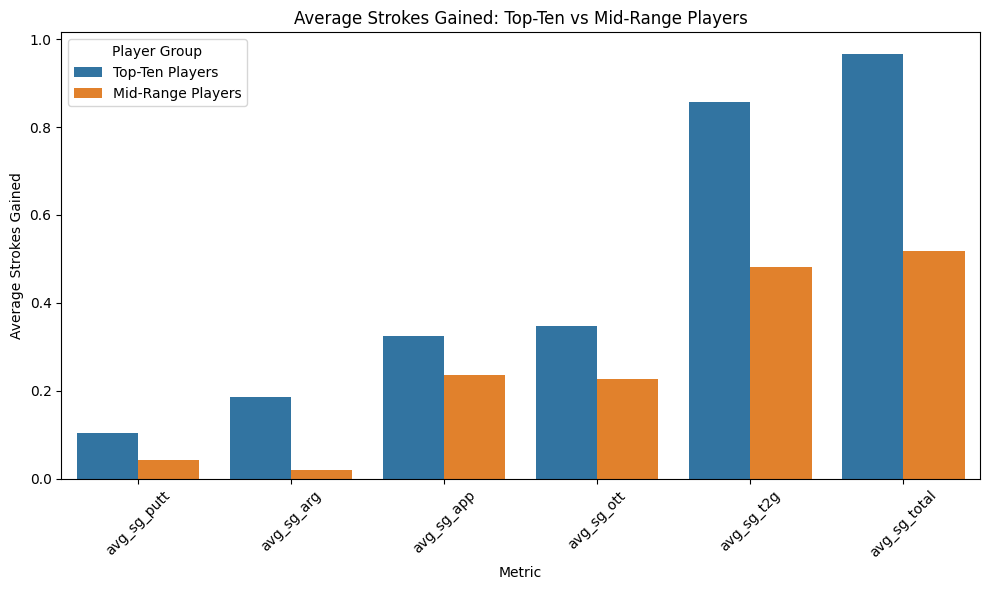

In [ ]:
sg_features_avg = ['avg_sg_putt', 'avg_sg_arg', 'avg_sg_app', 'avg_sg_ott', 'avg_sg_t2g', 'avg_sg_total']

plot_df = pd.DataFrame({
    'Strokes Gained Metric': sg_features_avg,
    'Top-Ten Players': top_15_players[sg_features_avg].mean().values,
    'Mid-Range Players': new_mid_band_list[sg_features_avg].mean().values
})

plot_df_melted = plot_df.melt(
    id_vars='Strokes Gained Metric', 
    var_name='Player Group', 
    value_name='Average SG'
)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Strokes Gained Metric', 
    y='Average SG', 
    hue='Player Group', 
    data=plot_df_melted
)
plt.title('Average Strokes Gained: Top-Ten vs Mid-Range Players')
plt.ylabel('Average Strokes Gained')
plt.xlabel('Metric')
plt.xticks(rotation=45)
plt.legend(title='Player Group')
plt.tight_layout()
plt.show()

C:\Users\dmiln\AppData\Local\Temp\ipykernel_9628\2324439562.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


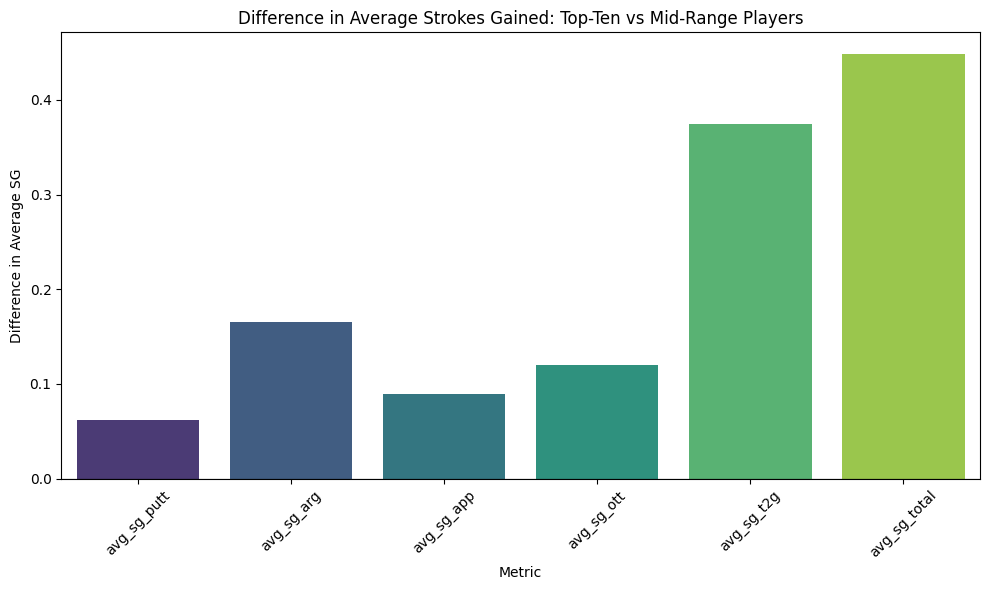

In [ ]:
top_ten_avg = top_15_players[sg_features_avg].mean()
mid_avg = new_mid_band_list[sg_features_avg].mean()

diff = top_ten_avg - mid_avg

diff_df = pd.DataFrame({
    'Strokes Gained Metric': sg_features_avg,
    'Difference (Top-Ten - Mid-Range)': diff.values
})

plt.figure(figsize=(10,6))
sns.barplot(
    x='Strokes Gained Metric', 
    y='Difference (Top-Ten - Mid-Range)', 
    data=diff_df, 
    palette='viridis'
)
plt.title('Difference in Average Strokes Gained: Top-Ten vs Mid-Range Players')
plt.ylabel('Difference in Average SG')
plt.xlabel('Metric')
plt.xticks(rotation=45)
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


Interestingly. these results are in stark contrast to the previous set analysing all golfers. For those already at a a level to perform to a standard to regularly finish 11-30th, it would appear the skills of chipping (around the green) and driving (off the tee) are the most in need of development. This suggests that targeted development in these specific skills could help mid-range players bridge the gap to top-ten performance.

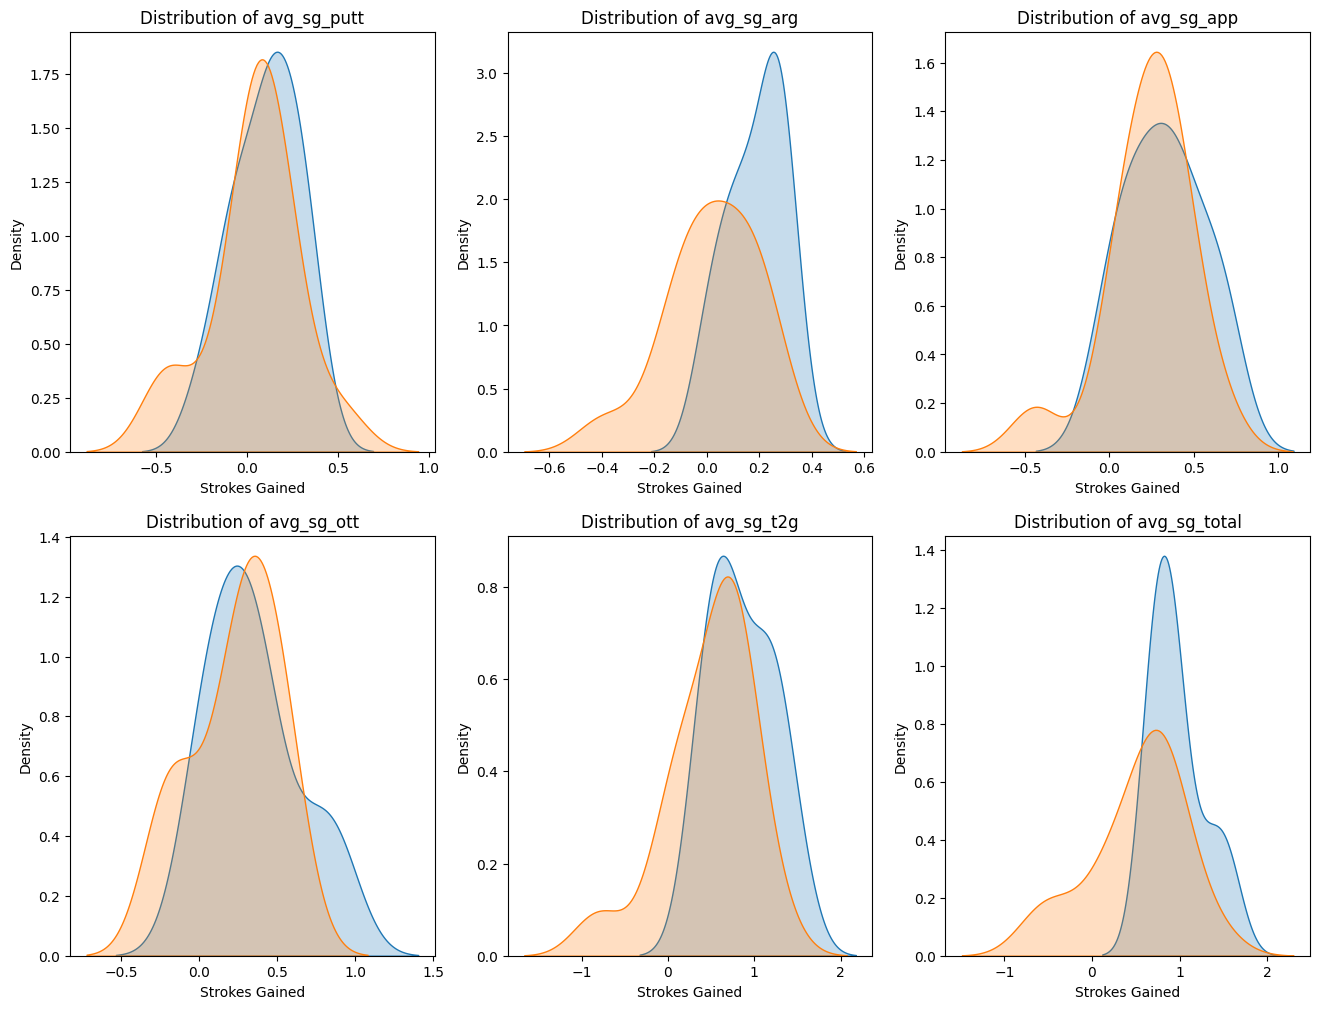

In [ ]:
plt.figure(figsize=(16, 12))

for i, metric in enumerate(sg_features_avg, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(top_15_players[metric], label='Top-Ten Players', fill=True)
    sns.kdeplot(new_mid_band_list[metric], label='Mid-Range Players', fill=True)
    plt.title(f'Distribution of {metric}')
    plt.xlabel('Strokes Gained')
    plt.ylabel('Density')
    plt.legend



The KDE plot further emphasises the difference in the 'around the green' metric for elite players in comparison to mid-range players. A Number of mid-range players even slip into negative around the green statistics, whereas elite players are all of a very similar standard of performance. 

## Conclusions and Next Steps ##

- Approach Play and Putting are the factors most correlated with top-ten performance. This contradicts Hypothesis 1 and will be communicated to the client.

- Chipping and Driving show the largest differential between mid-range golfers (regularly finishing 11th–30th) and elite golfers (regularly finishing in the top ten). This contradicts Hypothesis 2 and will be communicated to the client.

- No single strokes gained skill shows a very strong correlation with top-ten finishes, which aligns with Hypothesis 3.

- Further analyses using feature importance and model coefficients will be conducted during the machine learning stage to provide more robust answers to both business requirements.

- Next, additional data cleaning (beyond what has already been done) and feature engineering will be undertaken to prepare the dataset for machine learning.